# Нейросеть для сегментации изображений

## Описание проекта

Задача проекта сводится к классификации каждого пикселя. Необходимо определить к какому объекту (классу) он принадлежит. После, выделить на изображении части принадлежащие одному объекту, т.е. сегментировать изображение.

### Входные данные

•	Датасет в папке `fishki_labelme`:
- набор из 140 изображений (2448x2448x3 JPG);
- файлы разметки в формате `.json` из [labelme](https://github.com/wkentaro/labelme);
- файл `obj.names` с именами объектов/классов:
    - __background__ - фоновые пиксели;
    - fishka - пиксели области фишки;
    - defect - пиксели области дефекта.

•	Скрипт `01_generate_dataset.py` - генерирует датасет для обучения НС в формате [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/). Он также разбивает выборку на train (95%) и val и test (5%). Последние 2 выборки одинаковые (val=test).

### Задачи

**Задача №1:** _Подготовка датасета_

Скрипт `01_generate_dataset.py` нужно модифицировать (или написать свой) чтобы он разбивал исходный набор отдельно на train(80%) val(10%) и test(10%).
Выходными данными должны являться:
Готовый к обучению датасет в формате [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/);

**Задача №2:** _Обучение НС_

Необходимо обучить НС сегментатора на датасете из задачи №1.
Фреймворк машинного обучения и библиотеки можно использовать любые по желанию. Необходимо обосновать выбор.
Входное разрешение нейросети при обучении необходимо также выбрать и обосновать.

Выходными данными должны являться
-	обученная нейросеть сегментации с train датасетом из задачи №1;
-	лог обучения (графики функции потерь и mIoU от эпохи);
-	расчет метрик по сегментации на val датасете (IoU по каждому классу отдельно и mIoU);
-	расчет метрик по сегментации на test датасете (IoU по каждому классу отдельно и mIoU);

**Задача №3:** _Инференс НС_

Необходимо прогнать изображения из тестового датасета через обученную в задаче №2 нейросеть сегментатора и получить визуализации.
При выполнении задания можно использовать средства фреймворка машинного обучения (`PyTorch`, `Tensorflow`), либо сконвертировать обученную НС в формат ONNX.

Выходными данными должны являться изображения из полученного в задаче №1 test датасета размеченные обученной в задаче №2 нейросетью.

По результату тестового задания должен быть представлен краткий отчет с описанием выполненных работ, результатов тестирования НС и примерами изображений размеченных нейросетью.

*Примечание*: в данном случае для примера сделана просто визуализация разметки, вы должны будете сделать раскраску по результатам сегментации входных изображений нейросетью.
___

## Библиотеки и модули

Отдельно хочу отметить применение библиотеки `TensorFlow`. Изображение представляет из себя трёх-мерный массив со значение яркости базового цвета в конкретном пикселе. Предстоит обрабатывать целые наборы из изображений. Эта библиотека позволяет оперировать многомерными тензорами, а так же имеет встроенные модели, подходящие для поставленных задач.

In [1]:
# импорт основных библиотек
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# импорт спец. модулей
from skimage import measure
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.filters import gaussian

# проверка наличия GPU-ускорителя
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

GPU is OFF


## Вспомогательные функции

Некоторые ключевые значения будут многократно использоваться на протяжении всего проекта. По этой пречине они будут зафиксированы в самом начале в виде **констант**:

- `CLASSES` - кол-во классов + один класс обозначающий задний план
- `COLORS` - цветовое обозначение классов _[фон, фишка, дефект]_
- `SAMPLE_SIZE` - размер _входного_ изображения для НС
- `OUTPUT_SIZE` - размер изображения на _выходе_ НС

In [2]:
CLASSES = 3
COLORS = ['black', 'red', 'green']
SAMPLE_SIZE = (256, 256)
OUTPUT_SIZE = (2448, 2448)

Далее следует 3 вспомогательные функций,каждая из которых объявлена в индивидуальной ячейке, а их ключевых частей и строчек кода сделано при помощи комментариев в коде.

In [3]:
# функция загрузки и преобразования фото и маски
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE) # стандартизация размера фото я маски
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image * 0.8 # избавление от засветов
    image = image / 255.0 # нормализация фото (масштабирование будущих признаков)

    # аналогичная операция выполняется для маски
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    # создание многоканальной маски (индивидуальной для каждого объекта)
    masks = []
    uniq_values, uniq_id = tf.unique(tf.reshape(mask, [-1]))

    for tone in [ 0., 38., 75.]:
        masks.append(tf.where(tf.equal(mask, tone), 1.0, 0.0))

    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    # назначение входного для НС размера фото
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

In [4]:
# функция аугментация фото и маски
def augmentate_images(image, masks):
    # увеличение масштаба на случайную величину
    random_crop = tf.random.uniform((), 0.8, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)

    # отражение по горизонтали
    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)

    # коррекция размера после изменения изображения
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

In [5]:
# функция формирования датасетов
def get_image_dataset(sample):
    images = []
    masks  = []
    
    # загрузка имён фото и соответствующих масок
    file = open('fishki_voc_dataset/ImageSets/Segmentation/' + sample + '.txt', 'r')
    for line in file:
        images.append('fishki_voc_dataset/JPEGImages\\' + line[:-1] + '.jpg')
        masks.append('fishki_voc_dataset/SegmentationClass\\'+ line[:-1] +'.png')
    file.close()

    # формирование набора данных
    images_dataset = tf.data.Dataset.from_tensor_slices(images)
    masks_dataset  = tf.data.Dataset.from_tensor_slices(masks)
    dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

    return dataset

## Подготовка данных

Загрузка датасетов, сформированных при помощи скрипт `01_generate_dataset.py`.
Обучающая выборка состоит из 112 объектов. Она слишком мала для качественного обучения НС. По этой причине будет выполнена аугментация. Таким образом она будет увеличена в 10 раз, и каждый объект будет уникален.

In [6]:
# обучающая выборка
train = get_image_dataset('train')
train = train.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)       # загрузка данных в память с помощью функции load_images
train = train.repeat(10)                                                  # копирование датасета в памяти N раз
train = train.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE) # аугментация датасета с помощью функции augmentate_images
train = train.batch(14)

# валидационная выборка
valid = get_image_dataset('val')
valid = valid.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
valid = valid.batch(14)

# тестовая выборка
test = get_image_dataset('test')
test = test.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(14)

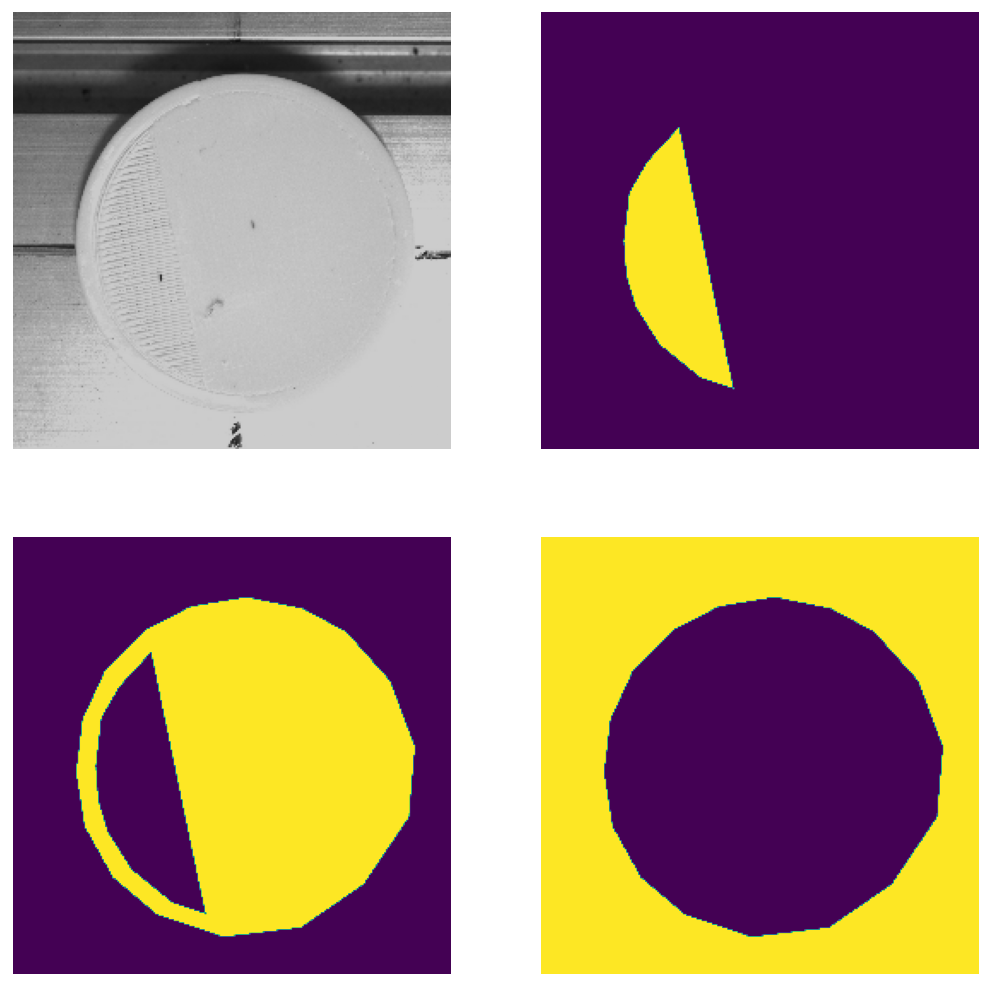

In [7]:
# контроль загрузки фото и корректной обработки маски
image, masks = load_images('fishki_voc_dataset/JPEGImages/00000001.jpg', 'fishki_voc_dataset/SegmentationClass/00000001.png')

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10), dpi=125)
ax[0, 0].set_axis_off()
ax[0, 0].imshow(image)

ax[0, 1].imshow(masks[:, :, 2])
ax[0, 1].set_axis_off()

ax[1, 0].imshow(masks[:, :, 1])
ax[1, 0].set_axis_off()

ax[1, 1].imshow(masks[:, :, 0])
ax[1, 1].set_axis_off()

plt.show()

## Основные слои НС

Для сегментации изображения будет сформирована [U-Net](https://arxiv.org/pdf/1505.04597.pdf) подобная нейронная сеть, которая состоит из двух основных частей:

- **Encoder** - последовательность из нескольких свёрточных слоёв в паре со слоями нормализации. В угоду упрощения конструкции НС, взамен `Pooling`-слоёв будет увеличен шаг свёртки (`strides=2`), выполняющий аналгичную функцию. За активацию нейрона будет отвечать отдельный слой `ReLU`.
- **Decoder** - последовательность из аналогичного количества слоёв обратной свёртки, попарно связанный со слоями пакетной нормализации `BatchNormalization`.

Далее следует описание парных слоёв (блоков) и их параметров. Формирование структуры НС из объявленных блоков. И создание связей `skip-connections`. Они позволяют восстановить пространственное расположение объектов, выявленных на этапах свёртки.

In [8]:
# входной слой (размерность = разрешение 3х канального изображения)
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))


# свёрточный блок
def downsample_block(filters, size, batch_norm=True):
    model = tf.keras.Sequential()

    initializer = tf.keras.initializers.GlorotNormal()
    model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.LeakyReLU())
    return model


# обратный свёрточный блок
def upsample_block(filters, size, dropout=False):
    model = tf.keras.Sequential()

    initializer = tf.keras.initializers.GlorotNormal()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    model.add(tf.keras.layers.BatchNormalization())

    if dropout:
        model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.ReLU())
    return model


# выходной слой
def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same', kernel_initializer=initializer, activation='sigmoid')

In [9]:
# структура нейронной сети
inp_layer = input_layer()

# Encoder
downsample_stack = [
    downsample_block(32, 4, batch_norm=False),
    downsample_block(64, 4),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(256, 4),
    downsample_block(256, 4)]

# Decoder
upsample_stack = [
    upsample_block(256, 4, dropout=True),
    upsample_block(256, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(64, 4),
    upsample_block(32, 4)]

out_layer = output_layer(4)

In [10]:
# добавление skip-connections связей
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)

downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Тестовая метрика, сформированная на основе двух наиболее популярных: `dice` и `binary_crossentropy`. Первая хорошо подходит для задач сегминтации изображения, а вторая имеет хорошую сходимость. Это дополнительная, вспомогательная метрика, помимо метрики `IoU`, указанной в задании.

In [11]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)

    dice_summ = 0

    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator

    avg_dice = dice_summ / CLASSES

    return avg_dice


def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)


def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [12]:
# компилирование НС
unet_like.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_mc_metric])

## Обучение и тестирование НС

Задача обучения HC сводится к минимизации функции ошибки на этапе классификации пикселей.

In [13]:
history_dice = unet_like.fit(train, validation_data=valid, epochs=25, initial_epoch=0)

unet_like.save_weights('SemanticSegmentationNetworks/unet_like')

Epoch 1/25
80/80 [==============================] - 233s 3s/step - loss: 0.3654 - dice_mc_metric: 0.5579 - val_loss: 4.6165 - val_dice_mc_metric: 0.2896
Epoch 2/25
80/80 [==============================] - 236s 3s/step - loss: 0.1704 - dice_mc_metric: 0.6779 - val_loss: 2.6883 - val_dice_mc_metric: 0.3037
Epoch 3/25
80/80 [==============================] - 240s 3s/step - loss: 0.1211 - dice_mc_metric: 0.7308 - val_loss: 0.9041 - val_dice_mc_metric: 0.3928
Epoch 4/25
80/80 [==============================] - 235s 3s/step - loss: 0.0850 - dice_mc_metric: 0.7631 - val_loss: 1.2813 - val_dice_mc_metric: 0.4010
Epoch 5/25
80/80 [==============================] - 235s 3s/step - loss: 0.0664 - dice_mc_metric: 0.7893 - val_loss: 0.6146 - val_dice_mc_metric: 0.4956
Epoch 6/25
80/80 [==============================] - 230s 3s/step - loss: 0.0514 - dice_mc_metric: 0.8119 - val_loss: 0.1337 - val_dice_mc_metric: 0.6010
Epoch 7/25
80/80 [==============================] - 226s 3s/step - loss: 0.0484 - 

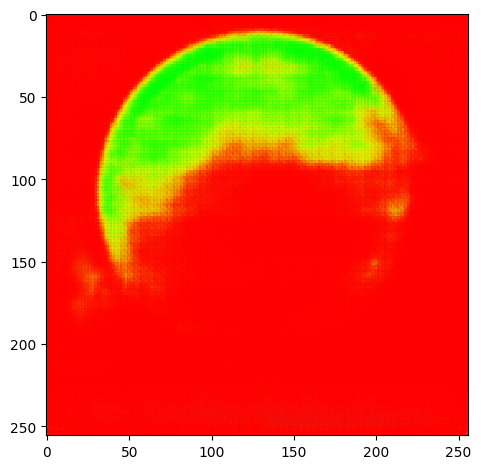

In [17]:
# образец предсказания
val_predict = unet_like.predict(test)
imshow(val_predict[1, :, :])

In [16]:
val_predict[1].shape

(256, 256, 3)

## Вывод